In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 행 많이보기
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 지수 표현 안보기
# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])
# 무형 제거

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)

# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)


Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


# Seasonality 

In [15]:
cate_dict = {
    '농수축' : [[20,21,23],[0,6],0.26],
    '이미용' : [[19,20,21,22,23],[0,6],-0.22],
    '가전' : [[22],[0,5,6],-0.5],
    '침구' : [[11,12,13,14,15,16],[0,6],2],
    '속옷' : [[20,21,22],[0,5,6],0.2],
    '건강기능' : [[19,20],[3,4,5,6],0.9],
    '의류' : [[20,21,22],[5,6],0.25],
    '생활용품': [[20,21,22],[0,6],-0.25],
    '주방' : [[20,21,22],[0,6],-0.3],
    '잡화' : [[None],[5,6],-0.4],
    '가구' : [[21,22],[0,5],-0.9]
}

In [16]:
data['time_month']    = data['time'].dt.month        # 월(숫자)
data['time_day']        = data['time'].dt.day          # 일(숫자)
data['time_hour']       = data['time'].dt.hour         # 시(숫자)
data['time_minute']     = data['time'].dt.minute       # 분(숫자)
data['tiem_second']     = data['time'].dt.second       # 초(숫자)

In [17]:
import numpy as np
import copy
data['goldtime']=None
data['goldweek']=None
data['seasonality']=None

temp = copy.copy(data)

for i in cate_dict:
    data['goldtime'] = np.where(data['category']==i,
                              np.where(data['time'].dt.hour.isin(cate_dict[i][0]), 1 , 0),data['goldtime']
                        )
    data['goldweek'] = np.where(data['category']==i,
                              np.where(data['time'].dt.weekday.isin(cate_dict[i][1]), 1 , 0),data['goldweek']
                        )
    data['seasonality'] = np.where(data['category']==i,cate_dict[i][2],data['seasonality'])

In [24]:
# 상품군 one-hot encoding
data_dummy = pd.get_dummies(data, columns=['category'], prefix='category', drop_first=True)

In [ ]:
data.drop(columns=['index','time','product_name','category','product_code'],inplace=True)

In [27]:
data_dummy.drop(columns=['index','time','product_name','product_code'],inplace=True)

In [29]:
data_dummy

,exposure_time,mcode,price,salesAMT,time_month,time_day,time_hour,time_minute,tiem_second,goldtime,goldweek,seasonality,category_가전,category_건강기능,category_농수축,category_생활용품,category_속옷,category_의류,category_이미용,category_잡화,category_주방,category_침구
0,20.0,100346,39900,2099000.0,1,1,6,0,0,0,0,0.25,0,0,0,0,0,1,0,0,0,0
1,20.0,100346,39900,4371000.0,1,1,6,0,0,0,0,0.25,0,0,0,0,0,1,0,0,0,0
2,20.0,100346,39900,3262000.0,1,1,6,20,0,0,0,0.25,0,0,0,0,0,1,0,0,0,0
3,20.0,100346,39900,6955000.0,1,1,6,20,0,0,0,0.25,0,0,0,0,0,1,0,0,0,0
4,20.0,100346,39900,6672000.0,1,1,6,40,0,0,0,0.25,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,20.0,100448,148000,10157000.0,12,31,23,40,0,0,0,-0.3,0,0,0,0,0,0,0,0,1,0
37368,20.0,100448,178000,50929000.0,1,1,0,0,0,0,0,-0.3,0,0,0,0,0,0,0,0,1,0
37369,20.0,100448,168000,104392000.0,1,1,0,0,0,0,0,-0.3,0,0,0,0,0,0,0,0,1,0
37370,20.0,100448,158000,13765000.0,1,1,0,0,0,0,0,-0.3,0,0,0,0,0,0,0,0,1,0


In [32]:
from sklearn.model_selection import train_test_split
train_y = data_dummy['salesAMT']
train_X = data_dummy.drop(columns='salesAMT', inplace=False)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=147, shuffle=True)

rf_model = RandomForestRegressor(n_jobs=-1)
# score = cross_val_score(rf_model, train_X, train_y, scoring=my_scorer, cv=kfold)
# print("교차 검증 점수:\n{}".format(score))

param_dist = {
    "max_depth": [7, 11, 15, 18, 21],
    "max_features": sp_randint(1, len(train_X.keys())+1),
    "min_samples_split": sp_randint(2, 21),
    "min_samples_leaf": sp_randint(1, 21),
    "bootstrap": [True, False],
    "random_state": [147]
}

n_iter_search = 20
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=n_iter_search)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                

In [35]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.650 (std: 0.019)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 147}

Model with rank: 2
Mean validation score: 0.640 (std: 0.020)
Parameters: {'bootstrap': False, 'max_depth': 18, 'max_features': 13, 'min_samples_leaf': 12, 'min_samples_split': 14, 'random_state': 147}

Model with rank: 3
Mean validation score: 0.619 (std: 0.021)
Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 14, 'min_samples_leaf': 19, 'min_samples_split': 4, 'random_state': 147}



In [36]:
rf_model2 = RandomForestRegressor(
    n_estimators=300,
    n_jobs=-1,
    bootstrap = False,
    max_depth = 15,
    max_features = 6,
    min_samples_leaf = 2,
    min_samples_split = 10,
    random_state = 147
)

In [37]:
rf_model2.fit(X_train, y_train)
pred = rf_model2.predict(X_test)


In [38]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

mape(y_test, pred)

733.4738333871954

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45733 missing from c

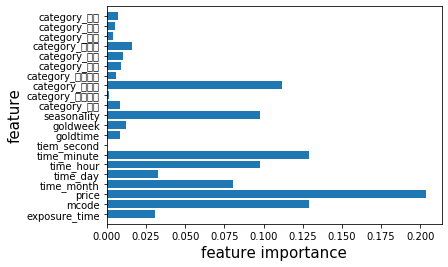

In [39]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf_model2.feature_importances_, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

In [65]:
columns=['mcode','price','seasonality','time_month','time_day','time_hour','time_minute','category_농수축']

In [66]:
train_y = data_dummy['salesAMT']
train_X = data_dummy[columns]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=147, shuffle=True)

rf_model = RandomForestRegressor(n_jobs=-1)
# score = cross_val_score(rf_model, train_X, train_y, scoring=my_scorer, cv=kfold)
# print("교차 검증 점수:\n{}".format(score))

param_dist = {
    "max_depth": [7, 11, 15, 18, 21],
    "max_features": sp_randint(1, len(train_X.keys())+1),
    "min_samples_split": sp_randint(2, 21),
    "min_samples_leaf": sp_randint(1, 21),
    "bootstrap": [True, False],
    "random_state": [147]
}

n_iter_search = 20
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=n_iter_search)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                

In [68]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.650 (std: 0.019)
Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 20, 'random_state': 147}

Model with rank: 2
Mean validation score: 0.648 (std: 0.021)
Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 17, 'random_state': 147}

Model with rank: 3
Mean validation score: 0.628 (std: 0.022)
Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 6, 'min_samples_leaf': 12, 'min_samples_split': 6, 'random_state': 147}



In [69]:
rf_model2 = RandomForestRegressor(
    n_estimators=300,
    n_jobs=-1,
    bootstrap = False,
    max_depth = 21,
    max_features = 4,
    min_samples_leaf = 6,
    min_samples_split = 20,
    random_state = 147
)

In [70]:
rf_model2.fit(X_train, y_train)
pred = rf_model2.predict(X_test)

mape(y_test, pred)

654.078919425864

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52629 missing from curre

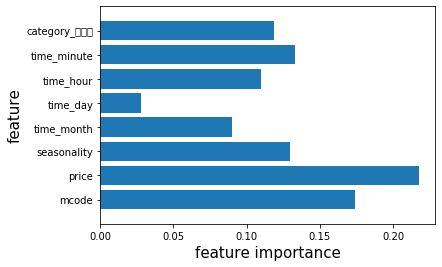

In [71]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf_model2.feature_importances_, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

In [ ]:
#V2